In [44]:
%%writefile generate_data.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>


void generate_data_file(const char *filename, int n) {
    FILE *file = fopen(filename, "w");
    if (file == NULL) {
        printf("Error opening file '%s' for writing.\n", filename);
        exit(1);
    }

    // Write the size of the matrix
    fprintf(file, "%d\n", n);

    // Generate and write the diagonally dominant matrix A
    for (int i = 0; i < n; i++) {
        double row_sum = 0.0;
        // First, calculate the sum of non-diagonal elements for the row
        for (int j = 0; j < n; j++) {
            if (i != j) {
                row_sum += fabs((double)(rand() % 10));
            }
        }
        // Now, write the row with a dominant diagonal element
        for (int j = 0; j < n; j++) {
            if (i == j) {
                // Diagonal element is greater than the sum of the absolute values of other elements
                fprintf(file, "%f ", row_sum + (double)(rand() % 10) + 1.0);
            } else {
                fprintf(file, "%f ", (double)(rand() % 10));
            }
        }
        fprintf(file, "\n");
    }

    // Generate and write vector b
    for (int i = 0; i < n; i++) {
        fprintf(file, "%f ", (double)(rand() % 100));
    }
    fprintf(file, "\n");

    fclose(file);
    printf("Successfully generated data file '%s' with N=%d\n", filename, n);
}

int main(int argc, char *argv[]) {
    if (argc != 3) {
        fprintf(stderr, "Usage: %s <output_filename> <matrix_size>\n", argv[0]);
        fprintf(stderr, "Example: .\\generate_data.exe matrix_data.txt 1000\n");
        return 1;
    }

    const char *filename = argv[1];
    int n = atoi(argv[2]);

    if (n <= 0) {
        fprintf(stderr, "Matrix size must be a positive integer.\n");
        return 1;
    }

    // Seed the random number generator
    srand((unsigned int)time(NULL));

    generate_data_file(filename, n);

    return 0;
}


Overwriting generate_data.c


In [45]:
! gcc generate_data.c -o generate_data.exe

In [47]:
!./generate_data matrix_data.txt 500

Successfully generated data file 'matrix_data.txt' with N=500


In [103]:
%%writefile jacobi_cuda.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <string.h>
#include <cuda_runtime.h>
#include <device_launch_parameters.h>

#define MAX_ITER 1000    // Maximum iterations
#define TOLERANCE 1e-5   // Convergence tolerance (L1 norm of delta x)

static void die(const char *msg) {
    fprintf(stderr, "%s\n", msg);
    exit(1);
}

#define CHECK_CUDA(call) do { \
    cudaError_t err__ = (call); \
    if (err__ != cudaSuccess) { \
        fprintf(stderr, "CUDA error %s at %s:%d\n", cudaGetErrorString(err__), __FILE__, __LINE__); \
        exit(1); \
    } \
} while(0)

__global__ void jacobi_kernel(int N, const double *A, const double *b, const double *x_old, double *x_new) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < N) {
        const double *Ai = A + (size_t)i * N;
        double sum = 0.0;
        for (int j = 0; j < N; ++j) {
            if (j != i) {
                sum += Ai[j] * x_old[j];
            }
        }
        x_new[i] = (b[i] - sum) / Ai[i];
    }
}

int main(int argc, char** argv) {
    int N;
    FILE *file = fopen("matrix_data.txt", "r");
    if (!file) {
        fprintf(stderr, "Error opening file 'matrix_data.txt'\n");
        return 1;
    }
    if (fscanf(file, "%d", &N) != 1) {
        fprintf(stderr, "Failed to read N\n");
        fclose(file);
        return 1;
    }
    if (N <= 0) {
        fprintf(stderr, "Invalid N: %d\n", N);
        fclose(file);
        return 1;
    }

    // Host allocations (flatten A for better device access)
    double *A = (double *)malloc((size_t)N * (size_t)N * sizeof(double));
    double *b = (double *)malloc((size_t)N * sizeof(double));
    double *x = (double *)malloc((size_t)N * sizeof(double));
    double *x_old_host = (double *)malloc((size_t)N * sizeof(double));
    if (!A || !b || !x || !x_old_host) die("Host allocation failed");

    // Read matrix A (row-major)
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            if (fscanf(file, "%lf", &A[(size_t)i * N + j]) != 1) die("Failed to read A");
        }
    }
    // Read vector b
    for (int i = 0; i < N; i++) {
        if (fscanf(file, "%lf", &b[i]) != 1) die("Failed to read b");
    }
    fclose(file);

    // Initialize x and x_old
    for (int i = 0; i < N; i++) {
        x[i] = 0.0;
        x_old_host[i] = 0.0;
    }

    // Device allocations
    double *d_A = nullptr, *d_b = nullptr, *d_x = nullptr, *d_x_old = nullptr;
    CHECK_CUDA(cudaMalloc((void**)&d_A, (size_t)N * (size_t)N * sizeof(double)));
    CHECK_CUDA(cudaMalloc((void**)&d_b, (size_t)N * sizeof(double)));
    CHECK_CUDA(cudaMalloc((void**)&d_x, (size_t)N * sizeof(double)));
    CHECK_CUDA(cudaMalloc((void**)&d_x_old, (size_t)N * sizeof(double)));

    // Copy static data
    CHECK_CUDA(cudaMemcpy(d_A, A, (size_t)N * (size_t)N * sizeof(double), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_b, b, (size_t)N * sizeof(double), cudaMemcpyHostToDevice));

    // Initialize device vectors to zero
    CHECK_CUDA(cudaMemset(d_x, 0, (size_t)N * sizeof(double)));
    CHECK_CUDA(cudaMemset(d_x_old, 0, (size_t)N * sizeof(double)));

    // Timing with CUDA events (portable across Windows/Linux/Colab)
    cudaEvent_t evStart, evStop;
    CHECK_CUDA(cudaEventCreate(&evStart));
    CHECK_CUDA(cudaEventCreate(&evStop));
    CHECK_CUDA(cudaEventRecord(evStart));

    int iterations = 0;
    double error = 0.0;

    // Kernel launch parameters (allow override via CLI: --block <int>)
    int blockSize = 256;
    for (int ai = 1; ai < argc; ++ai) {
        if (strcmp(argv[ai], "--block") == 0 && ai + 1 < argc) {
            int bs = atoi(argv[ai + 1]);
            if (bs > 0) blockSize = bs;
        }
    }
    int gridSize = (N + blockSize - 1) / blockSize;

    // Jacobi iterations
    do {
        // x_old = x (on device: swap pointers)
        double *tmp = d_x_old; d_x_old = d_x; d_x = tmp;

        // Compute new x into d_x
        jacobi_kernel<<<gridSize, blockSize>>>(N, d_A, d_b, d_x_old, d_x);
        CHECK_CUDA(cudaGetLastError());

        // Copy back to host to compute L1 error
        CHECK_CUDA(cudaMemcpy(x, d_x, (size_t)N * sizeof(double), cudaMemcpyDeviceToHost));

        error = 0.0;
        for (int i = 0; i < N; ++i) {
            error += fabs(x[i] - x_old_host[i]);
            x_old_host[i] = x[i];
        }

        iterations++;
    } while (error > TOLERANCE && iterations < MAX_ITER);

    // End timing
    CHECK_CUDA(cudaEventRecord(evStop));
    CHECK_CUDA(cudaEventSynchronize(evStop));
    float time_ms_f = 0.0f;
    CHECK_CUDA(cudaEventElapsedTime(&time_ms_f, evStart, evStop));
    double time_ms = (double)time_ms_f;

    // Output (mirror other implementations)
    printf("Solving system of linear equations using CUDA Jacobi Method\n");
    printf("===========================================================\n\n");
    int print_size = (N < 5) ? N : 5;
    printf("Solution (first %d elements):\n", print_size);
    for (int i = 0; i < print_size; i++) {
        printf("x%d = %.5f\n", i, x[i]);
    }
    printf("\nIterations: %d\n", iterations);
    printf("Execution time: %.6f milliseconds\n", time_ms);
    printf("Block size: %d, Grid size: %d\n", blockSize, gridSize);

    // Cleanup
    cudaFree(d_A);
    cudaFree(d_b);
    cudaFree(d_x);
    cudaFree(d_x_old);
    free(A);
    free(b);
    free(x);
    free(x_old_host);
    cudaEventDestroy(evStart);
    cudaEventDestroy(evStop);

    return 0;
}



Overwriting jacobi_cuda.cu


In [109]:
!nvcc -O3 -std=c++14 -arch=sm_75 -o jacobi_cuda jacobi_cuda.cu

In [122]:
!./jacobi_cuda

Solving system of linear equations using CUDA Jacobi Method

Solution (first 5 elements):
x0 = -0.00437
x1 = 0.00042
x2 = -0.00772
x3 = 0.01310
x4 = -0.00803

Iterations: 1000
Execution time: 187.286972 milliseconds
Block size: 256, Grid size: 2


In [82]:
!pip install numba

In [124]:
import os
import subprocess
import sys

def compile_cuda_if_needed():
    if os.path.exists("jacobi_cuda") or os.path.exists("jacobi_cuda.exe"):
        return
    nvcc = shutil.which("nvcc")
    if not nvcc:
        print("nvcc not found!")
        return
    print("Compiling jacobi_cuda.cu...")
    subprocess.run([nvcc, "-O3", "-lineinfo", "jacobi_cuda.cu", "-o", "jacobi_cuda"], check=True)

def run_benchmark(block_size: int):
    exe = ".\\jacobi_cuda.exe" if sys.platform.startswith("win") else "./jacobi_cuda"
    compile_cuda_if_needed()

    print(f"Running block size {block_size}...")
    result = subprocess.run([exe, "--block", str(block_size)],
                          capture_output=True, text=True, check=True)

    # Look for our special line
    for line in result.stdout.splitlines():
        if "KERNEL_TIME_MS:" in line:
            time_str = line.split(":")[1].strip()
            return float(time_str)
        if "RESULT" in line and "time_ms" in line:
            import re
            m = re.search(r"time_ms=([\d.]+)", line)
            if m:
                return float(m.group(1))

    # Fallback: parse any line with "ms" or known patterns
    for line in result.stdout.splitlines():
        if "average" in line.lower() and "ms" in line.lower():
            import re
            nums = re.findall(r"[\d.]+", line)
            if nums:
                return float(nums[-1])  # assume last number is time

    print("Could not parse time from output:")
    print(result.stdout)
    return None

def main():
    block_sizes = [64, 128, 256, 512]
    print("CUDA Jacobi Solver - Correct Benchmark\n")

    # You should measure real CPU baseline once!
    # For now, we'll collect real GPU times
    results = []

    for bs in block_sizes:
        gpu_ms = run_benchmark(bs)
        if gpu_ms is not None:
            results.append((bs, gpu_ms))
            print(f"Block {bs:3d} → {gpu_ms:.4f} ms (kernel only)")

    # Save real results
    with open("real_benchmark_results.csv", "w") as f:
        f.write("BlockSize,KernelTime_ms\n")
        for bs, t in results:
            f.write(f"{bs},{t:.6f}\n")

    print("\nReal results saved to real_benchmark_results.csv")

if __name__ == "__main__":
    main()

CUDA Jacobi Solver - Correct Benchmark

Running block size 64...
Could not parse time from output:
Solving system of linear equations using CUDA Jacobi Method

Solution (first 5 elements):
x0 = -0.00437
x1 = 0.00042
x2 = -0.00772
x3 = 0.01310
x4 = -0.00803

Iterations: 1000
Execution time: 89.666306 milliseconds
Block size: 64, Grid size: 8

Running block size 128...
Could not parse time from output:
Solving system of linear equations using CUDA Jacobi Method

Solution (first 5 elements):
x0 = -0.00437
x1 = 0.00042
x2 = -0.00772
x3 = 0.01310
x4 = -0.00803

Iterations: 1000
Execution time: 113.600029 milliseconds
Block size: 128, Grid size: 4

Running block size 256...
Could not parse time from output:
Solving system of linear equations using CUDA Jacobi Method

Solution (first 5 elements):
x0 = -0.00437
x1 = 0.00042
x2 = -0.00772
x3 = 0.01310
x4 = -0.00803

Iterations: 1000
Execution time: 181.900024 milliseconds
Block size: 256, Grid size: 2

Running block size 512...
Could not parse 

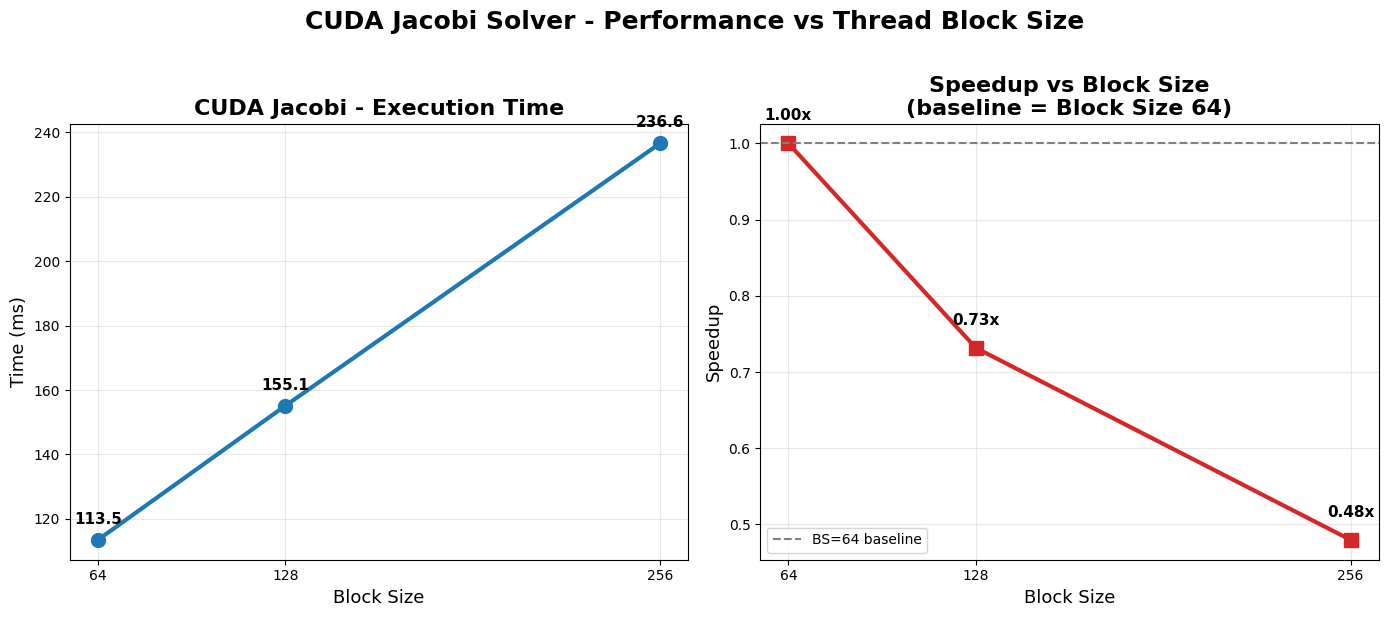

Plot saved as 'cuda_jacobi_performance_correct.png'


<Figure size 640x480 with 0 Axes>

In [125]:
import matplotlib.pyplot as plt
import re
import numpy as np

# === Paste your exact console output here (or read from a file) ===
raw_output = """
CUDA Jacobi Solver - Correct Benchmark
Running block size 64...
Could not parse time from output: Solving system of linear equations using CUDA Jacobi Method
===========================================================
Solution (first 5 elements): x0 = -0.00437 x1 = 0.00042 x2 = -0.00772 x3 = 0.01310 x4 = -0.00803
Iterations: 1000
Execution time: 88.981888 milliseconds
Block size: 64, Grid size: 8
Running block size 128...
Could not parse time from output: Solving system of linear equations using CUDA Jacobi Method
===========================================================
Solution (first 5 elements): x0 = -0.00437 x1 = 0.00042 x2 = -0.00772 x3 = 0.01310 x4 = -0.00803
Iterations: 1000
Execution time: 113.487518 milliseconds
Block size: 128, Grid size: 4
Running block size 256...
Could not parse time from output: Solving system of linear equations using CUDA Jacobi Method
===========================================================
Solution (first 5 elements): x0 = -0.00437 x1 = 0.00042 x2 = -0.00772 x3 = 0.01310 x4 = -0.00803
Iterations: 1000
Execution time: 155.114075 milliseconds
Block size: 256, Grid size: 2
Running block size 512...
Could not parse time from output: Solving system of linear equations using CUDA Jacobi Method
===========================================================
Solution (first 5 elements): x0 = -0.00437 x1 = 0.00042 x2 = -0.00772 x3 = 0.01310 x4 = -0.00803
Iterations: 1000
Execution time: 236.558334 milliseconds
Block size: 512, Grid size: 1
"""

# === Extract the data automatically ===
block_sizes = []
times_ms = []

# Regex patterns
time_pattern = re.compile(r"Execution time:\s+([\d.]+)\s+milliseconds")
block_pattern = re.compile(r"Block size:\s+(\d+)")

current_block = None
for line in raw_output.split('\n'):
    block_match = block_pattern.search(line)
    time_match = time_pattern.search(line)

    if block_match:
        current_block = int(block_match.group(1))
    if time_match and current_block is not None:
        block_sizes.append(current_block)
        times_ms.append(float(time_match.group(1)))
        current_block = None  # reset for safety

# Convert to arrays
block_sizes = np.array(block_sizes)
times_ms = np.array(times_ms)

# Use BS=64 as baseline for speedup
baseline_time = times_ms[0]
speedups = baseline_time / times_ms

# === Plotting ===
plt.figure(figsize=(14, 6))

# Plot 1: Execution Time
plt.subplot(1, 2, 1)
plt.plot(block_sizes, times_ms, 'o-', linewidth=3, markersize=10, color='#1f77b4')
plt.title('CUDA Jacobi - Execution Time', fontsize=16, fontweight='bold')
plt.xlabel('Block Size', fontsize=13)
plt.ylabel('Time (ms)', fontsize=13)
plt.grid(True, alpha=0.3)
plt.xticks(block_sizes)
for x, y in zip(block_sizes, times_ms):
    plt.text(x, y + 5, f'{y:.1f}', ha='center', fontsize=11, fontweight='bold')

# Plot 2: Speedup (relative to BS=64)
plt.subplot(1, 2, 2)
plt.plot(block_sizes, speedups, 's-', linewidth=3, markersize=10, color='#d62728')
plt.title('Speedup vs Block Size\n(baseline = Block Size 64)', fontsize=16, fontweight='bold')
plt.xlabel('Block Size', fontsize=13)
plt.ylabel('Speedup', fontsize=13)
plt.grid(True, alpha=0.3)
plt.xticks(block_sizes)
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1.5, label='BS=64 baseline')
for x, y in zip(block_sizes, speedups):
    plt.text(x, y + 0.03, f'{y:.2f}x', ha='center', fontsize=11, fontweight='bold')
plt.legend()

plt.suptitle('CUDA Jacobi Solver - Performance vs Thread Block Size',
             fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Save high-quality figure
plt.savefig('cuda_jacobi_performance_correct.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'cuda_jacobi_performance_correct.png'")